Recurrent Neural Network

Q1

7078
1.05 23.86


/home/student/Documents/220962436_Keshav/dllab/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0 th iteration :  tensor(0.0104, grad_fn=<MseLossBackward0>)
50 th iteration :  tensor(0.0068, grad_fn=<MseLossBackward0>)
100 th iteration :  tensor(0.0005, grad_fn=<MseLossBackward0>)
150 th iteration :  tensor(0.0006, grad_fn=<MseLossBackward0>)
200 th iteration :  tensor(0.0039, grad_fn=<MseLossBackward0>)
250 th iteration :  tensor(0.0040, grad_fn=<MseLossBackward0>)
300 th iteration :  tensor(0.0005, grad_fn=<MseLossBackward0>)
350 th iteration :  tensor(0.0020, grad_fn=<MseLossBackward0>)
400 th iteration :  tensor(0.0013, grad_fn=<MseLossBackward0>)
450 th iteration :  tensor(0.0023, grad_fn=<MseLossBackward0>)
500 th iteration :  tensor(0.0020, grad_fn=<MseLossBackward0>)
550 th iteration :  tensor(0.0026, grad_fn=<MseLossBackward0>)
600 th iteration :  tensor(0.0009, grad_fn=<MseLossBackward0>)
650 th iteration :  tensor(0.0020, grad_fn=<MseLossBackward0>)
700 th iteration :  tensor(0.0015, grad_fn=<MseLossBackward0>)
750 th iteration :  tensor(0.0003, grad_fn=<MseLossBackwar

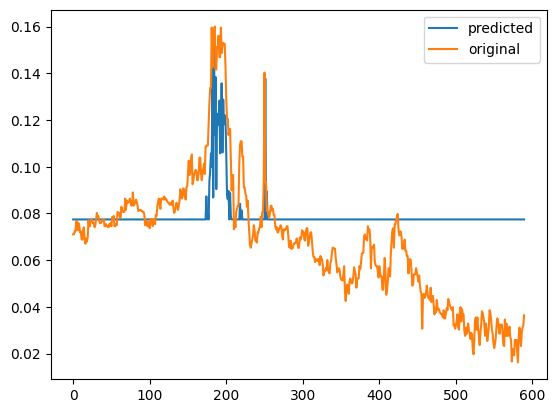

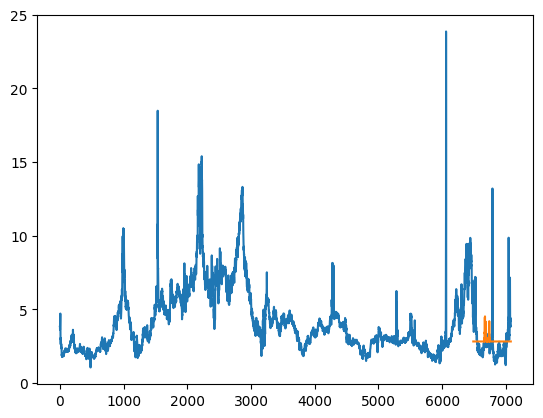

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn

df = pd.read_csv("daily.csv")
df = df.dropna()

y = df['Price'].values
x = np.arange(1, len(y), 1)
print(len(y))

minm = y.min()
maxm = y.max()
print(minm, maxm)

y = (y - minm) / (maxm - minm)
Sequence_Length = 10

X = []
Y = []
for i in range(0, 5900):
    list1 = []
    for j in range(i, i + Sequence_Length):
        list1.append(y[j])
    X.append(list1)
    Y.append(y[j + 1])

X = np.array(X)
Y = np.array(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.10, random_state=42, shuffle=False, stratify=None)

class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def __len__(self):
        return self.len
    
dataset = NGTimeSeries(x_train,y_train)
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset,shuffle=True,batch_size=256)

class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel,self).__init__()
        self.rnn = nn.RNN(input_size=1,hidden_size=5,num_layers=1,batch_first=True)
        self.fc1 = nn.Linear(in_features=5,out_features=1)

    def forward(self,x):
        output,_status = self.rnn(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output
    
model = RNNModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 1500
for i in range(epochs):
    for j, data in enumerate(train_loader):
        y_pred = model(data[:][0].view(-1, Sequence_Length,1)).reshape(-1)
        loss = criterion(y_pred, data[:][1])
        loss.backward()
        optimizer.step()
    if i % 50 == 0:
        print(i, "th iteration : ", loss)

test_set = NGTimeSeries(x_test,y_test)
test_pred = model(test_set[:][0].view(-1,10,1)).view(-1)
plt.plot(test_pred.detach().numpy(),label='predicted')
plt.plot(test_set[:][1].view(-1),label='original')
plt.legend()
plt.show()

y = y * (maxm - minm) + minm
y_pred = test_pred.detach().numpy() * (maxm - minm) + minm

plt.plot(y)
plt.plot(range(len(y)-len(y_pred), len(y)), y_pred)
plt.show()

Q2

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import glob
import unicodedata
import string
import random
import time
import math
import zipfile
from io import BytesIO
from urllib.request import urlopen

ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

def download_and_extract():
    url = "https://download.pytorch.org/tutorial/data.zip"
    with urlopen(url) as response:
        with zipfile.ZipFile(BytesIO(response.read())) as z:
            z.extractall()

# Function to convert unicode to ASCII
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if c in ALL_LETTERS
    )

# Read names and store them in dictionary
category_lines = {}
categories = []

def read_data():
    global category_lines, categories
    for filename in glob.glob('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        categories.append(category)
        lines = open(filename, encoding='utf-8').read().strip().split("\n")
        category_lines[category] = [unicode_to_ascii(line) for line in lines]

# Convert name into tensor
def name_to_tensor(name):
    tensor = torch.zeros(len(name), 1, N_LETTERS)
    for li, letter in enumerate(name):
        tensor[li][0][ALL_LETTERS.find(letter)] = 1
    return tensor

# Convert category to tensor
def category_to_tensor(category):
    return torch.tensor([categories.index(category)], dtype=torch.long)

# Define RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return self.softmax(output), hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Train the RNN
def train(category_tensor, name_tensor):
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    loss = 0
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

# Predict function
def predict(name):
    with torch.no_grad():
        tensor = name_to_tensor(name)
        hidden = rnn.init_hidden()
        for i in range(tensor.size()[0]):
            output, hidden = rnn(tensor[i], hidden)
        top_v, top_i = output.topk(1)
        return categories[top_i[0].item()]

# Initialize model and training parameters
download_and_extract()
read_data()
N_CATEGORIES = len(categories)
HIDDEN_SIZE = 128
rnn = RNN(N_LETTERS, HIDDEN_SIZE, N_CATEGORIES)
criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr=0.005)

# Train the model
n_iters = 100000
for iter in range(n_iters):
    category = random.choice(categories)
    name = random.choice(category_lines[category])
    category_tensor = category_to_tensor(category)
    name_tensor = name_to_tensor(name)
    output, loss = train(category_tensor, name_tensor)
    if iter % 5000 == 0:
        print(f'Iteration {iter}, Loss: {loss}')

# Test prediction
print(f'The predicted language is : {predict("Schmidt")}')  # Example prediction

Iteration 0, Loss: 2.907747745513916
Iteration 5000, Loss: 2.5389933586120605
Iteration 10000, Loss: 1.7482664585113525
Iteration 15000, Loss: 2.310732364654541
Iteration 20000, Loss: 2.3785476684570312
Iteration 25000, Loss: 3.5568957328796387
Iteration 30000, Loss: 3.37172794342041
Iteration 35000, Loss: 2.8595993518829346
Iteration 40000, Loss: 1.2245055437088013
Iteration 45000, Loss: 1.4183125495910645
Iteration 50000, Loss: 4.278039455413818
Iteration 55000, Loss: 0.2437611222267151
Iteration 60000, Loss: 0.00512334331870079
Iteration 65000, Loss: 1.9970269203186035
Iteration 70000, Loss: 2.0256400108337402
Iteration 75000, Loss: 0.11205734312534332
Iteration 80000, Loss: 0.1992700845003128
Iteration 85000, Loss: 0.65784752368927
Iteration 90000, Loss: 2.0528063774108887
Iteration 95000, Loss: 1.9455218315124512
The predicted language is : Scottish


Q3

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import string

# Define constants
ALL_LETTERS = string.ascii_lowercase
N_LETTERS = len(ALL_LETTERS)
HIDDEN_SIZE = 128

# Convert character to tensor
def char_to_tensor(char):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][ALL_LETTERS.find(char)] = 1
    return tensor

# Define RNN model
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return self.softmax(output), hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

# Generate training data
def generate_training_data():
    prefix_length = random.randint(1, 4)  # Generate short sequences
    start_idx = random.randint(0, N_LETTERS - prefix_length - 1)
    input_seq = ALL_LETTERS[start_idx:start_idx + prefix_length]
    target_char = ALL_LETTERS[start_idx + prefix_length]
    return input_seq, target_char

# Train the RNN
def train(model, optimizer, criterion, epochs=5000):
    for epoch in range(epochs):
        input_chars, target_char = generate_training_data()
        hidden = model.init_hidden()
        optimizer.zero_grad()

        for char in input_chars:
            input_tensor = char_to_tensor(char)
            output, hidden = model(input_tensor, hidden)

        target_tensor = torch.tensor(ALL_LETTERS.find(target_char), dtype=torch.long)
        loss = criterion(output, target_tensor.unsqueeze(0))
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Predict next character
def predict_next_char(model, input_chars):
    with torch.no_grad():
        hidden = model.init_hidden()
        for char in input_chars:
            input_tensor = char_to_tensor(char)
            output, hidden = model(input_tensor, hidden)
        top_v, top_i = output.topk(1)
        return ALL_LETTERS[top_i[0].item()]

# Initialize model, optimizer, and loss function
char_rnn = CharRNN(N_LETTERS, HIDDEN_SIZE, N_LETTERS)
optimizer = optim.SGD(char_rnn.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Train the model
train(char_rnn, optimizer, criterion)

# Test prediction
print("Predicted next character:", predict_next_char(char_rnn, "pqrst"))

Epoch 0, Loss: 3.300448417663574
Epoch 500, Loss: 3.233217477798462
Epoch 1000, Loss: 2.790496587753296
Epoch 1500, Loss: 2.3784751892089844
Epoch 2000, Loss: 2.322892189025879
Epoch 2500, Loss: 1.1175410747528076
Epoch 3000, Loss: 0.30704668164253235
Epoch 3500, Loss: 0.8363187909126282
Epoch 4000, Loss: 0.05210510641336441
Epoch 4500, Loss: 0.057970449328422546
Predicted next character: u
